# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [28]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows


Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

###PCA

Column Means: 
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

Column Variances: 
Fresh               1.599549e+08
Milk                5.446997e+07
Grocery             9.031010e+07
Frozen              2.356785e+07
Detergents_Paper    2.273244e+07
Delicatessen        7.952997e+06
dtype: float64

Principal Components:
[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]

Explained Variance Ratio:
[ 0.45961362  0.40517227  0.07003008  

(-0.25, 1)

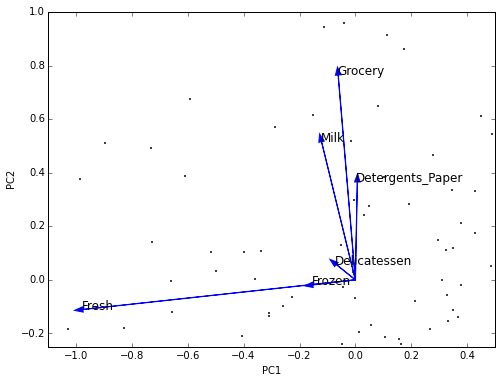

In [39]:
# Calculate column means
print "Column Means: "
print data.mean(axis = 0)
print ""

# Calculate column variances
print "Column Variances: "
print data.var(axis = 0)
print ""

# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print "Principal Components:"
print pca.components_
print ""
print "Explained Variance Ratio:"
print pca.explained_variance_ratio_

from sklearn.decomposition import PCA

def biplot(df):
    # Fit on 2 components
    pca = PCA(n_components=2, whiten=True).fit(df)

    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(8, 6), s=0.8)

    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(
        zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='blue', ec='blue')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)

    return ax

ax = biplot(data)
ax.set_xlim([-1.1, .5])
ax.set_ylim([-.25, 1])

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

###ICA

In [30]:
# Fit an ICA model to the data
# Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA(random_state = 33) 

# Convert data to float from int, center at the origin, and create ICs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.astype("float")
rescaled_data = scaler.fit_transform(data_scaled)
ica.fit(rescaled_data)

# Print the independent components
print "Independent Components: "
print ica.components_

Independent Components: 
[[ 0.44626755 -0.06580051 -0.07321083 -0.04050213  0.09919679 -0.04534492]
 [ 0.02959158 -0.18914986 -1.05717461  0.09079973  1.14168796  0.2729513 ]
 [ 0.04373215  0.01624421  0.05360334  0.03023994 -0.02017007 -0.86638632]
 [ 0.01819894  0.71999226 -0.55001984 -0.02094976  0.15001029 -0.28744399]
 [ 0.02226418 -0.12726945  0.6898219   0.01599167 -0.12936685 -0.09286756]
 [-0.09657435 -0.01076109  0.07221298  0.67836274 -0.02160608 -0.28720254]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [31]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Import Graphing Modules
import itertools

In [32]:
# Reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components=2).fit_transform(data)
print reduced_data[:10]  # print up to 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


Gaussian Mixture Models (GMM)

GMM with Lowest BIC: 
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=8, n_init=1, n_iter=100, params='wmc', random_state=3,
  thresh=None, tol=0.001)


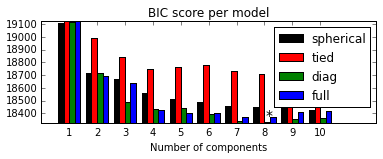

In [33]:
# Implement clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

# Create GMM with varying number of components, and covariance types
# Choose the GMM with lowest BIC
lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GMM(n_components=n_components, covariance_type=cv_type, random_state = 3)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clusters = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

print "Gaussian Mixture Models (GMM)"
print ""
print "GMM with Lowest BIC: "
print clusters

In [34]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [35]:
# Sample centroids from 3 best GMM models

# Find the centroids for best GMM 
print "Best Gaussian Mixture Model - " + str(clusters.means_.shape[0]) + " Centroids: "
centroids = clusters.means_
print centroids
print ""

# Find the centroids for 2nd best GMM
clusters2 = GMM(n_components=9, covariance_type = 'diag')
clusters2.fit(reduced_data)
print "2nd Best Gaussian Mixture Model - " + str(clusters2.means_.shape[0]) + " Centroids: "
print clusters2.means_
print ""

# Find the centroids for 3rd best GMM
clusters3 = GMM(n_components=6, covariance_type = 'diag')
clusters3.fit(reduced_data)
print "3rd Best Gaussian Mixture Model - " + str(clusters3.means_.shape[0]) + " Centroids: "
print clusters3.means_
print ""

Best Gaussian Mixture Model - 8 Centroids: 
[[ -19691.97729909   45688.76080332]
 [    454.96460816   -7661.51793015]
 [   2771.61549      14964.8735727 ]
 [   9403.49190821    5422.96562892]
 [ -26360.62555602   -8413.17639181]
 [   7536.85713524   -5271.65549509]
 [-103863.42532004    9910.34962857]
 [  -5560.93264448   -1033.10348831]]

2nd Best Gaussian Mixture Model - 9 Centroids: 
[[   -230.81032558   -7752.85220414]
 [    887.97264737   19951.31352983]
 [  -4655.45030336   -1179.42325344]
 [   9694.51600772    3350.48260545]
 [ -26359.40575878   -8362.70007696]
 [   7631.33207573   -5777.94168881]
 [ -25149.11932479   46360.0897332 ]
 [-103863.42532004    9910.34962857]
 [   6862.92113087   12033.52807819]]

3rd Best Gaussian Mixture Model - 6 Centroids: 
[[  2861.65386657  -7205.08465833]
 [-30694.20474719  -6800.62195173]
 [  9523.67164114   2891.98005651]
 [ -5213.55768901  -2696.38179275]
 [  3095.5895572   13834.59961502]
 [-19045.93038153  45993.78288564]]



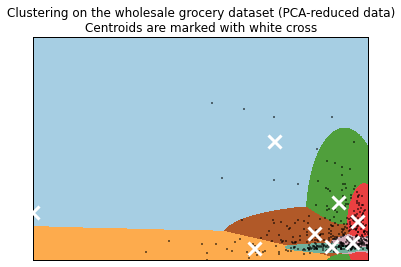

In [36]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

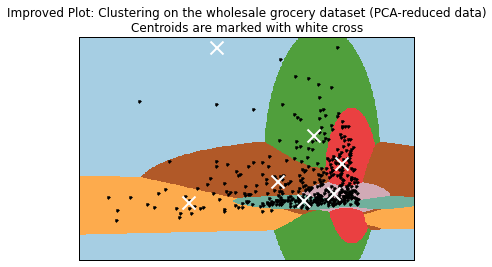

In [37]:
# Improve the plot to focus on bottom right

# Recreate mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min()/2, reduced_data[:, 0].max()*2
y_min, y_max = reduced_data[:, 1].min()*2, reduced_data[:, 1].max()/2
hx = (x_max-x_min)/500.
hy = (y_max-y_min)/500.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(2)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=6)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=2,
            color='w', zorder=10)
plt.title('Improved Plot: Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 